# Exercise 2: Training and Predictions
Neural Network Classification - Module 3

This exercise covers:
- Implementing the 5-step training loop
- Converting logits → probabilities → labels
- Using model.eval() and torch.inference_mode()
- Tracking training progress
- Calculating accuracy

Learning Mottos:
- If in doubt, run the code!
- Experiment, experiment, experiment!
- Visualize, visualize, visualize!

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
torch.manual_seed(42)
np.random.seed(42)

## Part 1: Setup and Data Preparation

In [17]:
X, y = make_circles(n_samples=1000, noise=0.03, factor=0.5, random_state=42)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [19]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).unsqueeze(1)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).unsqueeze(1)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [21]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

print(f"Training size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Training size: 800
Test size: 200


## Part 2: Define the Model

In [22]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super(CircleModelV0, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2, 8),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [23]:
model = CircleModelV0().to(device)
print(model)

CircleModelV0(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=1, bias=True)
  )
)


## Part 3: Loss Function and Optimizer

In [24]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Part 4: Training Loop (5 Steps)

In [25]:
epochs = 100
train_losses = []
train_accuracies = []

model.train()
for epoch in range(epochs):
    # Step 1: Forward pass
    y_logits = model(X_train)

    # Step 2: Calculate loss
    loss = criterion(y_logits, y_train)

    # Step 3: Zero gradients
    optimizer.zero_grad()

    # Step 4: Backward pass
    loss.backward()

    # Step 5: Optimizer step
    optimizer.step()

    # Track metrics
    train_losses.append(loss.item())
    with torch.no_grad():
        y_pred = (torch.sigmoid(y_logits) > 0.5).long()
        accuracy = (y_pred == y_train).float().mean()
        train_accuracies.append(accuracy.item())

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Acc: {accuracy.item()*100:.2f}%')

print("\nTraining complete!")

Epoch [10/100], Loss: 0.6938, Acc: 65.62%
Epoch [20/100], Loss: 0.6931, Acc: 60.12%
Epoch [30/100], Loss: 0.6932, Acc: 37.25%
Epoch [40/100], Loss: 0.6930, Acc: 53.62%
Epoch [50/100], Loss: 0.6929, Acc: 52.25%
Epoch [60/100], Loss: 0.6929, Acc: 49.75%
Epoch [70/100], Loss: 0.6929, Acc: 51.88%
Epoch [80/100], Loss: 0.6929, Acc: 51.00%
Epoch [90/100], Loss: 0.6929, Acc: 51.50%
Epoch [100/100], Loss: 0.6929, Acc: 51.00%

Training complete!


## Part 5: Visualizing Training Progress

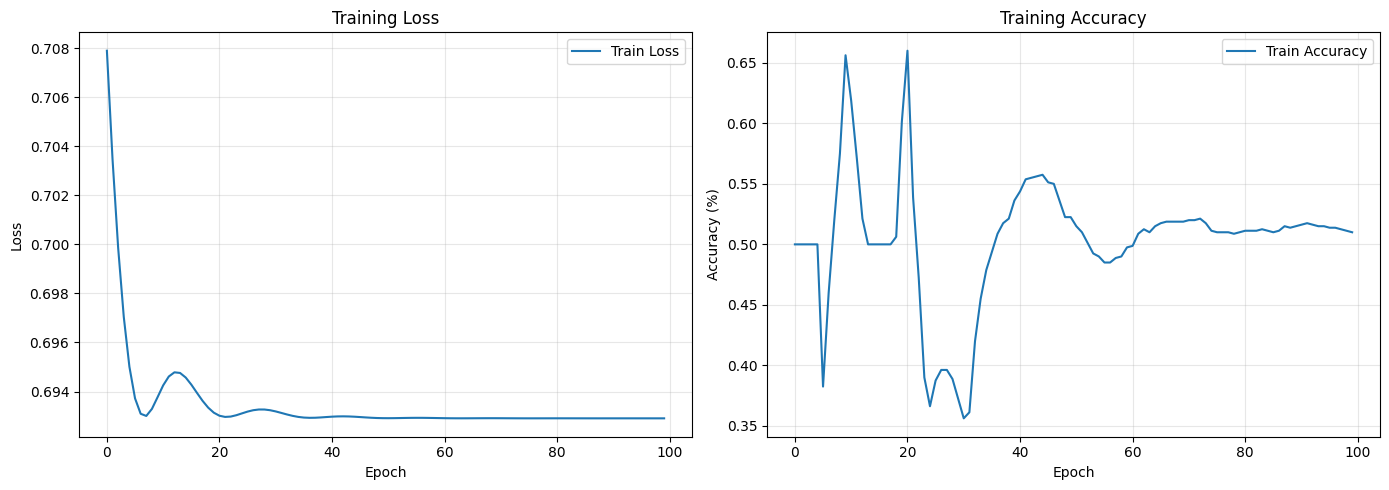

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(train_losses, label='Train Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(train_accuracies, label='Train Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 6: Inference Mode Predictions

In [27]:
model.eval()

with torch.inference_mode():
    test_logits = model(X_test)
    test_probs = torch.sigmoid(test_logits)
    test_preds = (test_probs > 0.5).long()

In [28]:
test_accuracy = (test_preds == y_test).float().mean()
print(f"Test Accuracy: {test_accuracy.item()*100:.2f}%")

Test Accuracy: 47.00%


In [29]:
print("\nFirst 5 predictions:")
for i in range(5):
    print(f"  Sample {i+1}:")
    print(f"    Logits: {test_logits[i].item():.4f}")
    print(f"    Probability: {test_probs[i].item():.4f}")
    print(f"    Predicted: {test_preds[i].item()}, Actual: {y_test[i].item()}")


First 5 predictions:
  Sample 1:
    Logits: 0.0264
    Probability: 0.5066
    Predicted: 1, Actual: 1.0
  Sample 2:
    Logits: 0.0724
    Probability: 0.5181
    Predicted: 1, Actual: 0.0
  Sample 3:
    Logits: -0.0242
    Probability: 0.4940
    Predicted: 0, Actual: 1.0
  Sample 4:
    Logits: 0.0653
    Probability: 0.5163
    Predicted: 1, Actual: 0.0
  Sample 5:
    Logits: -0.0295
    Probability: 0.4926
    Predicted: 0, Actual: 1.0


## Part 7: Understanding model.eval() and torch.inference_mode()

In [30]:
print("model.eval() vs model.train():")
print("  model.train() - Enables dropout and batch norm training behavior")
print("  model.eval()  - Disables dropout, uses running statistics")

print("\ntorch.inference_mode():")
print("  - Disables gradient calculation")
print("  - Faster than torch.no_grad()")
print("  - Use for making predictions")

print("\nCorrect inference pattern:")
print("  model.eval()")
print("  with torch.inference_mode():")
print("      predictions = model(X)")

model.eval() vs model.train():
  model.train() - Enables dropout and batch norm training behavior
  model.eval()  - Disables dropout, uses running statistics

torch.inference_mode():
  - Disables gradient calculation
  - Faster than torch.no_grad()
  - Use for making predictions

Correct inference pattern:
  model.eval()
  with torch.inference_mode():
      predictions = model(X)


## Part 8: Predictions Visualization

In [31]:
X_test_cpu = X_test.cpu().numpy()
y_test_cpu = y_test.cpu().numpy().squeeze()
test_preds_cpu = test_preds.cpu().numpy().squeeze()

C:\Users\LE TUAN DAT\AppData\Local\Temp\ipykernel_15856\3890137920.py:11: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test_cpu[incorrect_mask, 0], X_test_cpu[incorrect_mask, 1],


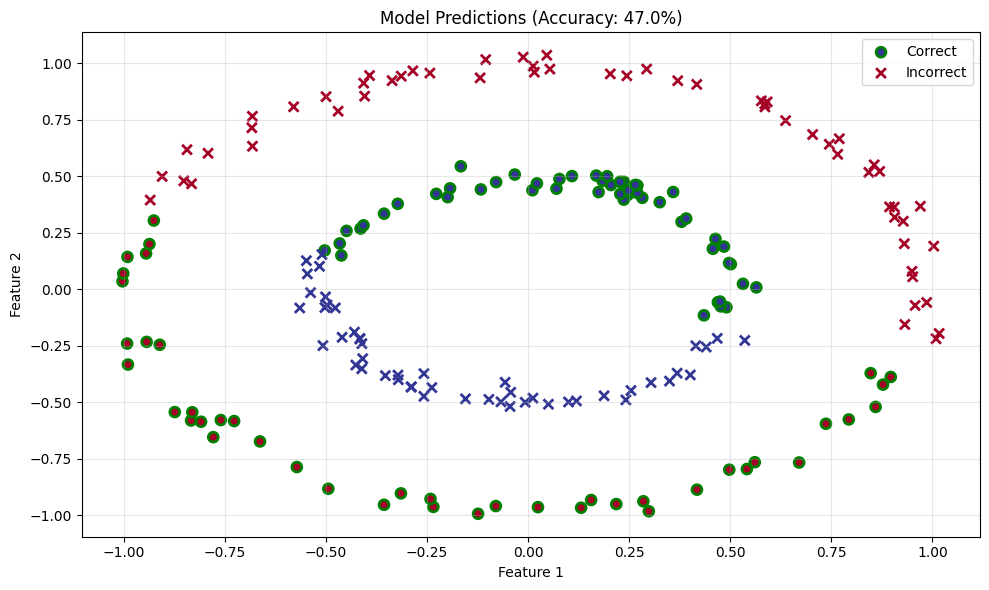

In [32]:
plt.figure(figsize=(10, 6))

# Correct predictions (green circles)
correct_mask = test_preds_cpu == y_test_cpu
plt.scatter(X_test_cpu[correct_mask, 0], X_test_cpu[correct_mask, 1],
            c=y_test_cpu[correct_mask], cmap='RdYlBu', s=50,
            marker='o', edgecolors='g', linewidths=2, label='Correct')

# Incorrect predictions (red X)
incorrect_mask = ~correct_mask
plt.scatter(X_test_cpu[incorrect_mask, 0], X_test_cpu[incorrect_mask, 1],
            c=y_test_cpu[incorrect_mask], cmap='RdYlBu', s=50,
            marker='x', edgecolors='r', linewidths=2, label='Incorrect')

plt.title(f'Model Predictions (Accuracy: {test_accuracy.item()*100:.1f}%)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Exercises

**Exercise 1: Try different thresholds**

In [34]:
results = {}

In [35]:
for threshold in [0.3, 0.5, 0.7]:
    model.eval()

    with torch.inference_mode():
        test_logits = model(X_test)
        test_probs = torch.sigmoid(test_logits)
        test_preds = (test_probs > threshold).long()

    results[threshold] = {
        "accuracy": (test_preds == y_test).float().mean().item() * 100,
        "predictions": test_preds.cpu().numpy(),
        "probs": test_probs.cpu().numpy(),
    }

In [39]:
import numpy as np

print(f"{'Threshold':<10} {'Accuracy':<10} {'Pred=1 (%)':<12}")
print("-" * 40)

for t, res in results.items():
    preds = res['predictions']
    acc = res['accuracy']
    ratio_ones = np.mean(preds) * 100
    print(f"{t:<10} {acc:<10.2f} {ratio_ones:<12.2f}")


Threshold  Accuracy   Pred=1 (%)  
----------------------------------------
0.3        50.00      100.00      
0.5        47.00      54.00       
0.7        50.00      0.00        


**Exercise 2: Experiment with learning rate**

In [40]:
learing_rates = [0.001, 0.01, 0.1]
all_results = {}

In [41]:
for lr in learing_rates:
    print(f"\n{'='*60}")
    print(f"Experiment with learning_rate={lr}")
    print(f"{'='*60}")
    results = {}

    model = CircleModelV0()
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    epochs = 100
    train_losses = []
    train_accuracies = []

    model.train()
    for epoch in range(epochs):
        y_logits = model(X_train)

        loss = criterion(y_logits, y_train)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_losses.append(loss.item())
        with torch.no_grad():
            y_pred = (torch.sigmoid(y_logits) > 0.5).long()
            accuracy = (y_pred == y_train).float().mean()
            train_accuracies.append(accuracy.item())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Acc: {accuracy.item()*100:.2f}%')

        results[epoch] = {
            "train_loss": loss.item(),
            "train_accuracy": accuracy.item() * 100
        }

    all_results[lr] = results


Experiment with learning_rate=0.001
Epoch [10/100], Loss: 0.7152, Acc: 46.88%
Epoch [20/100], Loss: 0.7117, Acc: 46.88%
Epoch [30/100], Loss: 0.7088, Acc: 46.88%
Epoch [40/100], Loss: 0.7063, Acc: 47.12%
Epoch [50/100], Loss: 0.7042, Acc: 47.12%
Epoch [60/100], Loss: 0.7025, Acc: 47.12%
Epoch [70/100], Loss: 0.7011, Acc: 47.25%
Epoch [80/100], Loss: 0.6999, Acc: 47.25%
Epoch [90/100], Loss: 0.6989, Acc: 47.37%
Epoch [100/100], Loss: 0.6980, Acc: 47.50%

Experiment with learning_rate=0.01
Epoch [10/100], Loss: 0.6936, Acc: 65.87%
Epoch [20/100], Loss: 0.6942, Acc: 50.00%
Epoch [30/100], Loss: 0.6932, Acc: 46.63%
Epoch [40/100], Loss: 0.6929, Acc: 54.25%
Epoch [50/100], Loss: 0.6930, Acc: 53.62%
Epoch [60/100], Loss: 0.6929, Acc: 51.50%
Epoch [70/100], Loss: 0.6929, Acc: 50.00%
Epoch [80/100], Loss: 0.6929, Acc: 51.25%
Epoch [90/100], Loss: 0.6929, Acc: 51.63%
Epoch [100/100], Loss: 0.6929, Acc: 51.00%

Experiment with learning_rate=0.1
Epoch [10/100], Loss: 0.6929, Acc: 53.37%
Epoch [2

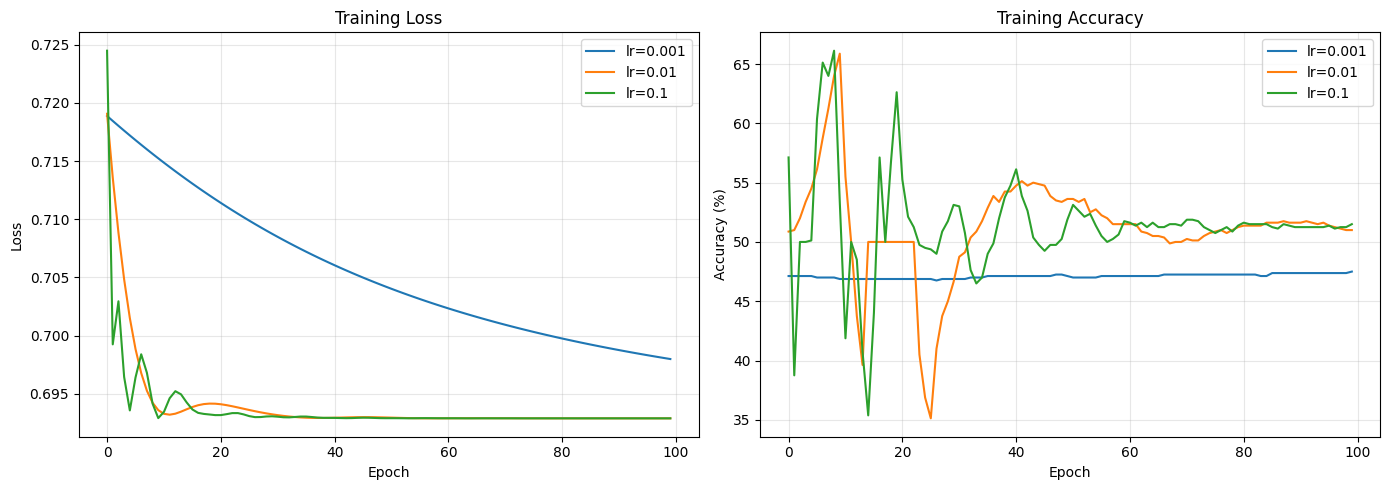

In [48]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ===== Training Loss =====
for lr, epochs_dict in all_results.items():
    epochs = sorted(epochs_dict.keys())
    losses = [epochs_dict[e]['train_loss'] for e in epochs]

    axes[0].plot(epochs, losses, label=f"lr={lr}")

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ===== Training Accuracy =====
for lr, epochs_dict in all_results.items():
    epochs = sorted(epochs_dict.keys())
    accs = [epochs_dict[e]['train_accuracy'] for e in epochs]

    axes[1].plot(epochs, accs, label=f"lr={lr}")

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Exercise 3: Track loss over epochs**

In [49]:
# Is the loss decreasing steadily?
"""
For lr = 0.001, the loss decreases steadily but very slowly.
For lr = 0.01, the loss drops quickly at the beginning and then stabilizes.
For lr = 0.1, the loss fluctuates strongly in early epochs before settling.

"""


# Is the training plateauing?
"""
Yes. For lr = 0.01 and lr = 0.1, both loss and accuracy reach a plateau after around 30–40 epochs, showing little improvement afterward.

"""


# Would more epochs help?
"""
No. Since the training has already plateaued, increasing the number of epochs would not significantly improve performance.
"""

'\nNo. Since the training has already plateaued, increasing the number of epochs would not significantly improve performance.\n'

**Exercise 4: Experiment with epochs**

In [57]:
epoch_list = [50, 100, 200, 500]
max_epoch = max(epoch_list)

model = CircleModelV0().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_results = {}
train_losses = []
train_accuracies = []

model.train()
for epoch in range(max_epoch):
    y_logits = model(X_train)
    loss = criterion(y_logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        y_pred = (torch.sigmoid(y_logits) > 0.5).long()
        acc = (y_pred == y_train).float().mean()

    train_losses.append(loss.item())
    train_accuracies.append(acc.item() * 100)

    if (epoch + 1) in epoch_list:
        all_results[epoch + 1] = {
            "loss_curve": train_losses.copy(),
            "accuracy_curve": train_accuracies.copy(),
            "final_loss": loss.item(),
            "final_accuracy": acc.item() * 100
        }

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{max_epoch}] "
              f"Loss: {loss.item():.4f}, Acc: {acc.item()*100:.2f}%")


Epoch [10/500] Loss: 0.7512, Acc: 50.00%
Epoch [20/500] Loss: 0.7424, Acc: 50.00%
Epoch [30/500] Loss: 0.7347, Acc: 50.00%
Epoch [40/500] Loss: 0.7280, Acc: 50.00%
Epoch [50/500] Loss: 0.7223, Acc: 50.00%
Epoch [60/500] Loss: 0.7173, Acc: 50.00%
Epoch [70/500] Loss: 0.7131, Acc: 50.00%
Epoch [80/500] Loss: 0.7094, Acc: 50.00%
Epoch [90/500] Loss: 0.7063, Acc: 50.00%
Epoch [100/500] Loss: 0.7037, Acc: 50.00%
Epoch [110/500] Loss: 0.7014, Acc: 50.00%
Epoch [120/500] Loss: 0.6996, Acc: 50.00%
Epoch [130/500] Loss: 0.6981, Acc: 50.00%
Epoch [140/500] Loss: 0.6968, Acc: 50.00%
Epoch [150/500] Loss: 0.6959, Acc: 50.00%
Epoch [160/500] Loss: 0.6951, Acc: 50.00%
Epoch [170/500] Loss: 0.6945, Acc: 50.00%
Epoch [180/500] Loss: 0.6940, Acc: 50.00%
Epoch [190/500] Loss: 0.6937, Acc: 49.38%
Epoch [200/500] Loss: 0.6934, Acc: 40.75%
Epoch [210/500] Loss: 0.6933, Acc: 37.75%
Epoch [220/500] Loss: 0.6931, Acc: 35.00%
Epoch [230/500] Loss: 0.6931, Acc: 39.88%
Epoch [240/500] Loss: 0.6930, Acc: 43.75%
E

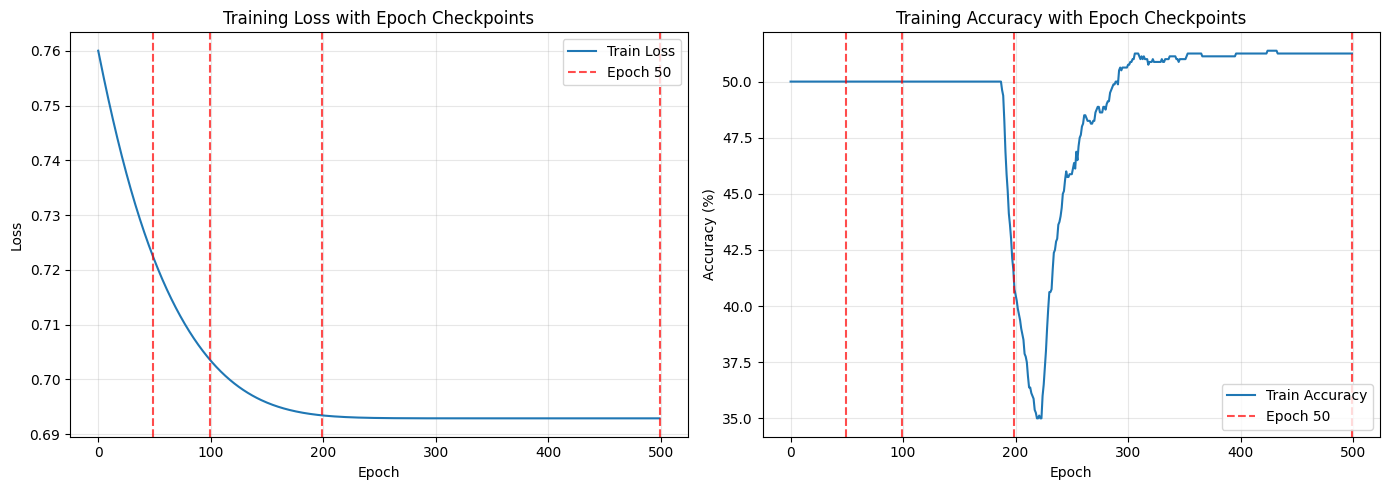

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ======================
# Loss curve
# ======================
axes[0].plot(train_losses, label='Train Loss')

for ep in epoch_list:
    axes[0].axvline(
        x=ep-1, color='red', linestyle='--', alpha=0.7,
        label=f'Epoch {ep}' if ep == epoch_list[0] else None
    )

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss with Epoch Checkpoints')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


# ======================
# Accuracy curve
# ======================
axes[1].plot(train_accuracies, label='Train Accuracy')

for ep in epoch_list:
    axes[1].axvline(
        x=ep-1, color='red', linestyle='--', alpha=0.7,
        label=f'Epoch {ep}' if ep == epoch_list[0] else None
    )

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training Accuracy with Epoch Checkpoints')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Exercise 5: Compare model.eval() vs not using it**

In [59]:
# =====================================================
# Case 1: CORRECT – use model.eval()
# =====================================================
model.eval()  # 🔥 IMPORTANT

with torch.no_grad():
    logits_eval = model(X_test)
    loss_eval = criterion(logits_eval, y_test)

    preds_eval = (torch.sigmoid(logits_eval) > 0.5).long()
    acc_eval = (preds_eval == y_test).float().mean()

print("With model.eval():")
print(f"  Test Loss: {loss_eval.item():.4f}")
print(f"  Test Accuracy: {acc_eval.item()*100:.2f}%")

With model.eval():
  Test Loss: 0.6954
  Test Accuracy: 47.00%


In [60]:
# =====================================================
# Case 2: WRONG – forget model.eval()
# =====================================================
model.train()  # ❌ simulate forgetting model.eval()

with torch.no_grad():
    logits_no_eval = model(X_test)
    loss_no_eval = criterion(logits_no_eval, y_test)

    preds_no_eval = (torch.sigmoid(logits_no_eval) > 0.5).long()
    acc_no_eval = (preds_no_eval == y_test).float().mean()

print("\nWithout model.eval():")
print(f"  Test Loss: {loss_no_eval.item():.4f}")
print(f"  Test Accuracy: {acc_no_eval.item()*100:.2f}%")

print("=" * 60)


Without model.eval():
  Test Loss: 0.6954
  Test Accuracy: 47.00%


In [62]:
"""
In a linear model, model.eval() has no effect since there are no layers whose behavior depends on training or evaluation mode.
"""

'\nIn a linear model, model.eval() has no effect since there are no layers whose behavior depends on training or evaluation mode.\n'